In [2]:
import numpy as np  
import scipy.io as sio
from scipy import linalg
import matplotlib.pyplot as plt
#contents = sio.loadmat('A.mat')
#A = contents['A']

%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')

# Load  Document Data

In [3]:
inData = sio.loadmat('M.mat')
M = inData['M']

inData = sio.loadmat('Mcounts.mat')
Mcounts = inData['Mcounts']

inData = sio.loadmat('words.mat')
matlab_words = inData['words']
words = []
for i in range(matlab_words.shape[1]):
    words.append(matlab_words[0, i][0])
words = np.array(words, dtype=object)

inData = sio.loadmat('y.mat')
y = inData['y']

num_documents, num_words = M.shape
i1 = np.nonzero(y == -1)[0]
i2 = np.nonzero(y == 1)[0]
ii = np.nonzero(M > 0)[0]
n1 = len(i1)
n2 = len(i2)

frac_nonzero = len(ii) / (num_documents*num_words)
print("Class 1: %d items \nClass 2: %d items\n" % (n1, n2))
print('M is %d-by-%d, fraction of nonzero entries: %f\n' % (num_documents, num_words, len(ii)/(num_documents*num_words)))


Class 1: 71 items 
Class 2: 68 items

M is 139-by-18446, fraction of nonzero entries: 0.020787



# Calculate Information gain for each word

In [4]:
class1_bool = (y == 1).flatten()
class2_bool = (y == -1).flatten()
class1_counts = np.sum(Mcounts[class1_bool, :], axis=0)
class2_counts = np.sum(Mcounts[class2_bool, :], axis=0)
information_gain =np.abs(class1_counts - class2_counts)

# Define CUR Decomposition

In [5]:
def CUR(A, W, Vh, c, k, r):
    # A: input m x n array
    # W: The matrix of left singular vectors for A, m x rank(A) array
    # Vh: The matrix of right singular vectors for A, rankd(A) x n array
    # c, r: parameters for column/row selection likelihood
    # k: rank for choosing the rank-truncated SVD

    # Pick k highest left singular vectors
    Vk = Vh[0:k, :]
    Uk = W[:, 0:k]

    # Randomly select columns, rows with high statistical leverage
    [C, column_leverage] = columnselect(A, Vk, k, c)
    [R, row_leverage] = columnselect(A.T, Uk.T, k, r)
    R = R.T

    # Compute U
    Cinv = linalg.pinv(C)
    Rinv = linalg.pinv(R)
    U = np.dot(Cinv, np.dot(A, Rinv))

    return [C, U, R, column_leverage, row_leverage]

def columnselect(A, Vk, k, c):
    
    # Compute leverage scores
    leverage = (1/k)*np.sum(Vk**2, axis=0)
    
    # Randomyly pick columns to keep (according to leverage) 
    #keep_bool = np.zeros(A.shape[1], dtype=bool)
    uniform = np.random.uniform(0, 1, A.shape[1])
    keep_prob = np.minimum(1, c*leverage)
    keep_bool = uniform < keep_prob
        
    # If no columns chosen, choose the one with highest leverage
    if np.all(~keep_bool):
        j = np.argmax(leverage)
        keep_bool[j] = True

    Areduced = A[:, keep_bool]

    return [Areduced, leverage]


def getLeverage(A, W, Vh, k):
        # Pick k highest left singular vectors
    Vk = Vh[0:k, :]
    Uk = W[:, 0:k].T  
    # Compute leverage scores
    column_leverage = (1/k)*np.sum(Vk**2, axis=0)
    row_leverage = (1/k)*np.sum(Uk**2, axis=0)

    return [column_leverage, row_leverage]



## Print Out Words That Have High Leverage Scores

In [241]:
klist = np.arange(2, 20, 1)
column_xvals = np.arange(0, num_words, 1)
row_xvals = np.arange(0, num_documents, 1)
[W, S, Vh] = np.linalg.svd(M, full_matrices=False)
for k in klist:
    [column_leverage, row_leverage] = getLeverage(M, W, Vh, k)
    column_sorted_idx = np.argsort(-column_leverage)
    row_sorted_idx = np.argsort(-row_leverage)
    print("for rank k=%d, the top 5 highest leverage words are:" % k)
    print(words[column_sorted_idx[0:5]])
    print("\n")

print("The top 5 information gain words are:")
sorted_idx = np.argsort(-information_gain)
print(words[sorted_idx[0:5]])

    

for rank k=2, the top 5 highest leverage words are:
['and' 'the' 'for' 'with' 'this']


for rank k=3, the top 5 highest leverage words are:
['and' 'the' 'for' 'with' 'are']


for rank k=4, the top 5 highest leverage words are:
['and' 'the' 'for' 'with' 'gif']


for rank k=5, the top 5 highest leverage words are:
['and' 'the' 'for' 'with' 'gif']


for rank k=6, the top 5 highest leverage words are:
['and' 'the' 'for' 'with' 'contact']


for rank k=7, the top 5 highest leverage words are:
['and' 'the' 'for' 'gif' 'with']


for rank k=8, the top 5 highest leverage words are:
['and' 'the' 'for' 'gif' 'contact']


for rank k=9, the top 5 highest leverage words are:
['gif' 'and' 'the' 'for' 'contact']


for rank k=10, the top 5 highest leverage words are:
['gif' 'and' 'the' 'for' 'with']


for rank k=11, the top 5 highest leverage words are:
['gif' 'and' 'the' 'for' 'evansville']


for rank k=12, the top 5 highest leverage words are:
['gif' 'and' 'the' 'for' 'evansville']


for rank k=13, th

# Problem Number 3

In [93]:
klist = np.arange(2, 20, 4)
eps = 0.01
alpha_list = np.arange(0, 1, 0.2)

# Compute SVD
[W, S, Vh] = np.linalg.svd(M, full_matrices=False)

# Store errors according to (k, c, r), with c, r parametrized by alpha
error_table = np.zeros((len(klist), len(alpha_list), len(alpha_list)))

# Store SVD error for each k
error_SVD_table = np.zeros(len(klist))

for i in range(len(klist)):
    # Fix a value of rank k 
    k = klist[i]
    
    # Truncated SVD computation
    Vk = Vh[0:k, :]
    Uk = W[:, 0:k]
    Sk = np.diag(S[0:k])
    error_SVD = np.linalg.norm(M - np.dot(Uk, np.dot(Sk, Vk)))
    error_SVD_table[i] = error_SVD

    for j in range(len(alpha_list)):
        # Fix a value of c 
        c = (k*np.log(k))/(eps**2) + alpha_list[j]
        
        for q in range(len(alpha_list)):
            # Fix a value of r 
            r = (k*np.log(k))/(eps**2)  + alpha_list[q]

            # Average several CUR computations
            error_CUR_avg = 0
            for z in range(10):
                # CUR computation
                [C, U, R, _, _] = CUR(M, W, Vk, c, k, r, eps)
                error_CUR_avg += np.linalg.norm(M - np.dot(C, np.dot(U, R)))
            error_ratio_avg = (1/10)*(error_CUR_avg / error_SVD)

            # Store error ration corresponding to (k, c, r) choice 
            error_table[i, j, q]  = error_ratio_avg

#np.savez("error_table", error_table=error_table, epslist=epslist, klist=klist)
#np.savez("new_error_table", error_table=error_table, alpha_list=alpha_list, klist=klist)
np.savez("error_SVD_table", error_table=error_SVD_table,klist=klist)

 

# Problem 3: Create Error plots

[0.  0.2 0.4 0.6 0.8]


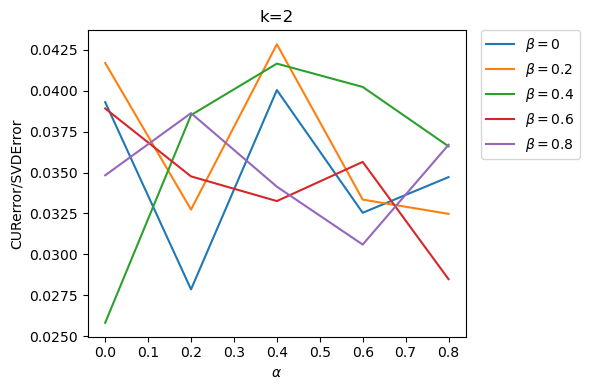

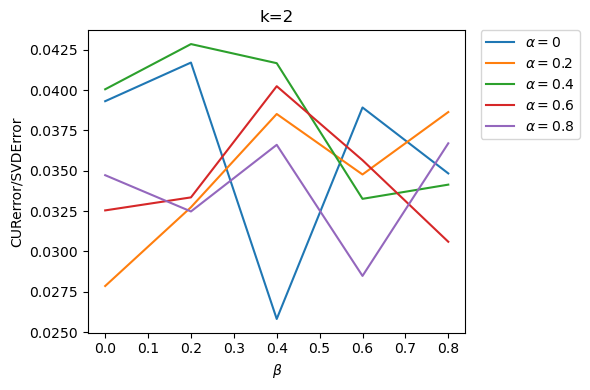

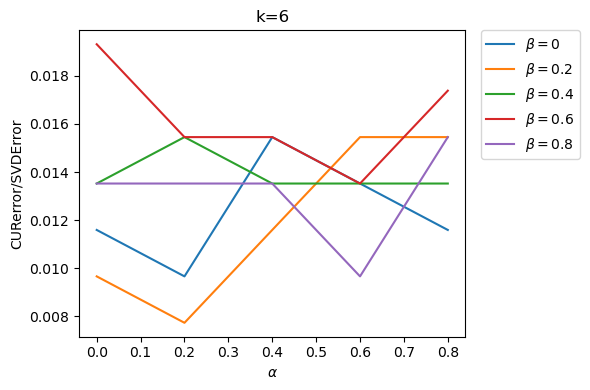

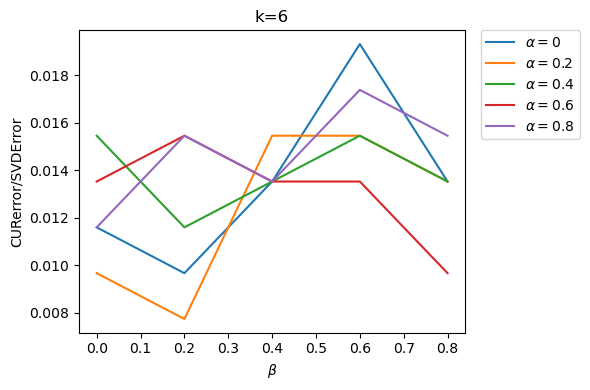

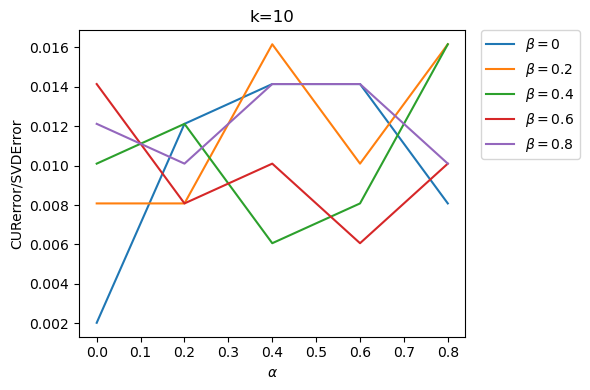

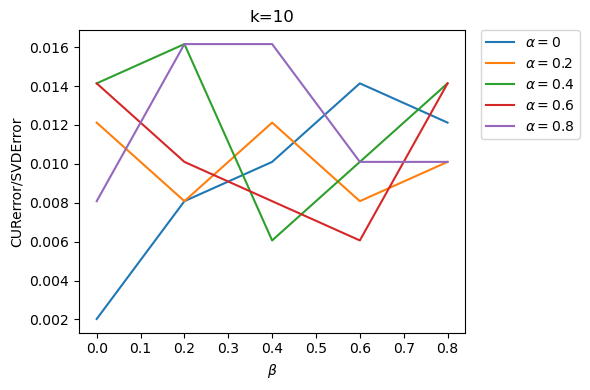

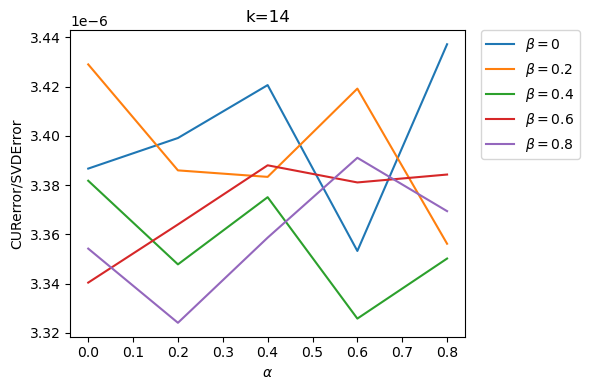

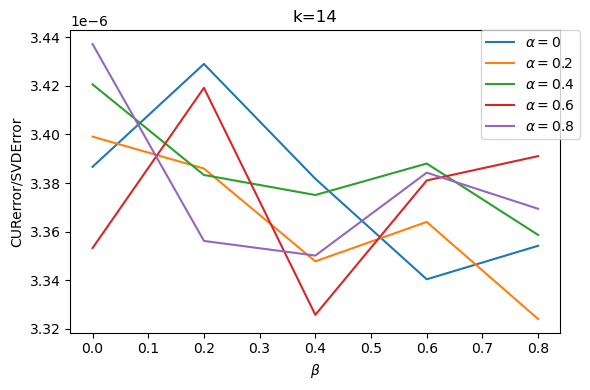

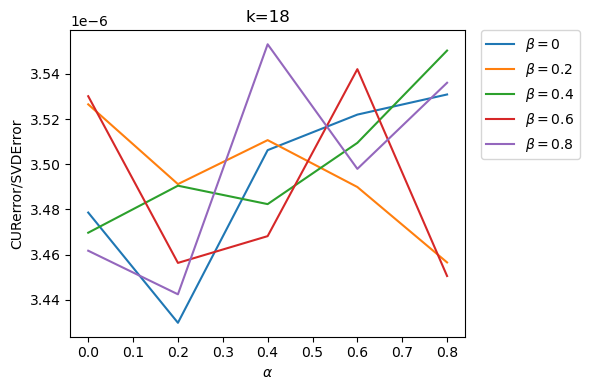

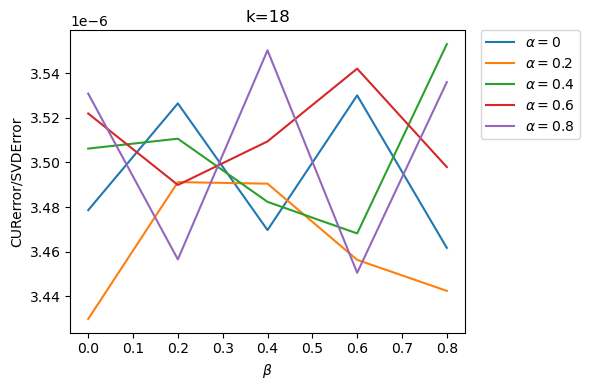

In [230]:
inData = np.load("new_error_table.npz")
new_error_table = inData["error_table"]
alphalist = inData["alpha_list"]
klist = inData["klist"]
print(alphalist)

plt.rcParams["figure.figsize"] = [6.00, 4.00]
plt.rcParams["figure.autolayout"] = True

for i in range(len(klist)):
    plt.figure()
    for idx in range(error_table.shape[2]):
        plt.plot(alphalist, new_error_table[i, :, idx])
        plt.legend([r'$\beta=0$', r'$\beta=0.2$', r'$\beta=0.4$', r'$\beta=0.6$', r'$\beta=0.8$'],bbox_to_anchor=(1.04,1), borderaxespad=0)
        plt.xlabel(r'$\alpha$')
        plt.ylabel('CURerror/SVDError')
        plt.title("k=%d" % klist[i])
    plt.tight_layout()
    fname = "k%d_alpha_fix.png" % klist[i]
    plt.savefig(fname, dpi=300)

    plt.figure()
    for idx in range(error_table.shape[2]):
        plt.plot(alphalist, new_error_table[i, idx, :])
        plt.legend([r'$\alpha=0$', r'$\alpha=0.2$', r'$\alpha=0.4$', r'$\alpha=0.6$', r'$\alpha=0.8$'], bbox_to_anchor=(1.04,1), borderaxespad=0)
        plt.xlabel(r'$\beta$')
        plt.ylabel('CURerror/SVDError')
        plt.title("k=%d" % klist[i])
    plt.tight_layout()
    fname = "k%d_beta_fix.png" % klist[i]
    plt.savefig(fname, dpi=300)




# Problem 4: Preprocessing, Comparison with Information Gain, Projection, and Clustering

In [ ]:
klist = np.arange(19, 20, 1)
column_xvals = np.arange(0, num_words, 1)
row_xvals = np.arange(0, num_documents, 1)

#class1_bool = (y == 1).flatten()
#class2_bool = (y == -1).flatten()
Mlabelled = M
Mlabelled[class2_bool, :] = Mlabelled[class2_bool, :] * -1
#class1_counts = np.sum(Mcounts[class1_bool, :], axis=0)
#class2_counts = np.sum(Mcounts[class2_bool, :], axis=0)
#information_gain =np.abs(class1_counts - class2_counts)

[W, S, Vh] = np.linalg.svd(Mlabelled, full_matrices=False)
for k in klist:
    [column_leverage, row_leverage] = getLeverage(Mlabelled, W, Vh, k)
    column_sorted_idx = np.argsort(-column_leverage)
    row_sorted_idx = np.argsort(-row_leverage)
    print("for rank k=%d, the top 20 highest leverage words are:" % k)
    print(words[column_sorted_idx[0:20]])
    print("\n")

print("The top 5 information gain words are:")
sorted_idx = np.argsort(-information_gain)
print(words[sorted_idx[0:5]])

